### Load Dataset

In [ ]:
!wget https://files.grouplens.org/datasets/movielens/ml-25m.zip

--2024-05-26 16:14:53--  https://files.grouplens.org/datasets/movielens/ml-25m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 261978986 (250M) [application/zip]
Saving to: ‘ml-25m.zip’

ml-25m.zip          100%[===================>] 249.84M   119MB/s    in 2.1s    

2024-05-26 16:14:55 (119 MB/s) - ‘ml-25m.zip’ saved [261978986/261978986]



In [ ]:
!unzip -qq ml-25m.zip

In [ ]:
file_ratings = '/content/ml-25m/ratings.csv'
file_movies = '/content/ml-25m/movies.csv'

In [ ]:
import numpy as np
import csv
import random

def create_movie_names(file_path):
    global movie_id_map
    movie_names = np.empty(N, dtype=object)

    with open(file_path, mode='r', newline='', encoding='utf-8') as file:
        reader = csv.DictReader(file)

        for row in reader:
            movie_id = np.int64(row['movieId'])
            movie_name = row['title']

            if movie_id not in movie_id_map:
                continue

            movie_index = movie_id_map[movie_id]
            movie_names[movie_index] = movie_name

    return movie_names


def create_rating_matrix(file_path):
    global user_id_map, movie_id_map
    ratings = []
    ratings_train = []
    ratings_test = []

    with open(file_path, mode='r', newline='', encoding='utf-8') as file:
        reader = csv.DictReader(file)

        for row in reader:
            user_id = np.int64(row['userId'])
            movie_id = np.int64(row['movieId'])
            rating = np.int64(float(row['rating']) * 2)

            if user_id not in user_id_map:
                user_id_map[user_id] = len(user_id_map)

            if movie_id not in movie_id_map:
                movie_id_map[movie_id] = len(movie_id_map)

            user_index = user_id_map[user_id]
            movie_index = movie_id_map[movie_id]

            ratings.append([user_index, movie_index, rating])

            random_number = random.random()
            # 80% train, 20% test
            if random_number <= 0.8:
                ratings_train.append([user_index, movie_index, rating])
            else:
                ratings_test.append([user_index, movie_index, rating])

    return np.array(ratings), np.array(ratings_train), np.array(ratings_test)


def index(ratings, index_type="user"):
    locations = []
    i = 0

    if index_type == "user":
        current_id = ratings[0][0]
    else:
        current_id = ratings[0][1]

    locations.append(i)
    for user_id, movie_id, _ in ratings:
        if index_type == "user":
            if current_id != user_id:
                locations.append(i)
                current_id = user_id
            i += 1
        else:
            if current_id != movie_id:
                locations.append(i)
                current_id = movie_id
            i += 1

    return np.array(locations)

In [ ]:
user_id_map = {}
movie_id_map = {}
ratings, ratings_train, ratings_test = create_rating_matrix(file_ratings)
N = len(movie_id_map)
M = len(user_id_map)

In [ ]:
movie_names = create_movie_names(file_movies)

In [ ]:
sorted_by_user_train = ratings_train[ratings_train[:, 0].argsort()]
sorted_by_user_test = ratings_test[ratings_test[:, 0].argsort()]

sorted_by_movie_train = ratings_train[ratings_train[:, 1].argsort()]
sorted_by_movie_test = ratings_test[ratings_test[:, 1].argsort()]

In [ ]:
user_index_train = index(sorted_by_user_train, "user")
user_index_test = index(sorted_by_user_test, "user")
movie_index_train = index(sorted_by_movie_train, "movie")
movie_index_test = index(sorted_by_movie_test, "movie")

In [ ]:
total_ratings_train = len(ratings_train)
total_ratings_test = len(ratings_test)
total_ratings = total_ratings_train + total_ratings_test
M_train = len(user_index_train)
M_test = len(user_index_test)
N_train = len(movie_index_train)
N_test = len(movie_index_test)

### ALS updates

In [ ]:
from numba import njit, prange
import numpy as np
import math

@njit
def cal_user_bias_update(rating_matrix, m, user_vector, movie_vector, user_biases, movie_biases, par_lambda, par_gamma, par_tau):
    movie_indices = rating_matrix[:, 1]
    ratings = rating_matrix[:, 2]

    sum_term = np.sum(0.5 * ratings - np.dot(movie_vector[movie_indices], user_vector[m]) - movie_biases[movie_indices])
    return (par_lambda * sum_term) / (par_lambda * len(movie_indices) + par_gamma)


@njit(parallel=True)
def user_bias_update(user_vector, movie_vector, user_biases, movie_biases, par_lambda, par_gamma, par_tau):
    new_user_biases = np.copy(user_biases)

    for m in prange(M_train):
        start_index = user_index_train[m]
        end_index = user_index_train[m + 1] if m + 1 < M_train else total_ratings_train
        rating_matrix = sorted_by_user_train[start_index:end_index]
        user = rating_matrix[0, 0]

        new_user_biases[user] = cal_user_bias_update(
            rating_matrix, user, user_vector, movie_vector, user_biases, movie_biases, par_lambda, par_gamma, par_tau
        )

    return new_user_biases


@njit
def cal_user_vector_update(rating_matrix, m, user_vector, movie_vector, user_biases, movie_biases, par_lambda, par_gamma, par_tau):
    movie_indices = rating_matrix[:, 1]
    ratings = rating_matrix[:, 2]

    t1 = (par_lambda * np.dot(movie_vector[movie_indices].T, movie_vector[movie_indices])) + (par_tau * np.eye(k))
    t2 = par_lambda * np.dot(movie_vector[movie_indices].T, 0.5 * ratings - user_biases[m] - movie_biases[movie_indices])

    return np.dot(np.linalg.inv(t1), t2)


@njit(parallel=True)
def user_vector_update(user_vector, movie_vector, user_biases, movie_biases, par_lambda, par_gamma, par_tau):
    new_user_vector = np.copy(user_vector)

    for m in prange(M_train):
        start_index = user_index_train[m]
        end_index = user_index_train[m + 1] if m + 1 < M_train else total_ratings_train
        rating_matrix = sorted_by_user_train[start_index:end_index]
        user = rating_matrix[0, 0]

        new_user_vector[user] = cal_user_vector_update(
            rating_matrix, user, user_vector, movie_vector, user_biases, movie_biases, par_lambda, par_gamma, par_tau
        )

    return new_user_vector


@njit
def cal_movie_bias_update(rating_matrix, n, user_vector, movie_vector, user_biases, movie_biases, par_lambda, par_gamma, par_tau):
    user_indices = rating_matrix[:, 0]
    ratings = rating_matrix[:, 2]

    sum_term = np.sum(0.5 * ratings - np.dot(user_vector[user_indices], movie_vector[n]) - user_biases[user_indices])
    return (par_lambda * sum_term) / (par_lambda * len(user_indices) + par_gamma)


@njit(parallel=True)
def movie_bias_update(user_vector, movie_vector, user_biases, movie_biases, par_lambda, par_gamma, par_tau):
    new_movie_biases = np.copy(movie_biases)

    for n in prange(N_train):
        start_index = movie_index_train[n]
        end_index = movie_index_train[n + 1] if n + 1 < N_train else total_ratings_train
        rating_matrix = sorted_by_movie_train[start_index:end_index]
        movie = rating_matrix[0, 1]

        new_movie_biases[movie] = cal_movie_bias_update(
            rating_matrix, movie, user_vector, movie_vector, user_biases, movie_biases, par_lambda, par_gamma, par_tau
        )

    return new_movie_biases


@njit
def cal_movie_vector_update(rating_matrix, n, user_vector, movie_vector, user_biases, movie_biases, par_lambda, par_gamma, par_tau):
    user_indices = rating_matrix[:, 0]
    ratings = rating_matrix[:, 2]

    t1 = (par_lambda * np.dot(user_vector[user_indices].T, user_vector[user_indices])) + (par_tau * np.eye(k))
    t2 = par_lambda * np.dot(user_vector[user_indices].T, 0.5 * ratings - movie_biases[n] - user_biases[user_indices])

    return np.dot(np.linalg.inv(t1), t2)


@njit(parallel=True)
def movie_vector_update(user_vector, movie_vector, user_biases, movie_biases, par_lambda, par_gamma, par_tau):
    new_movie_vector = np.copy(movie_vector)

    for n in prange(N_train):
        start_index = movie_index_train[n]
        end_index = movie_index_train[n + 1] if n + 1 < N_train else total_ratings_train
        rating_matrix = sorted_by_movie_train[start_index:end_index]
        movie = rating_matrix[0, 1]

        new_movie_vector[movie] = cal_movie_vector_update(
            rating_matrix, movie, user_vector, movie_vector, user_biases, movie_biases, par_lambda, par_gamma, par_tau
        )

    return new_movie_vector

### RMSE and Loss Calculation

In [ ]:
from numba import njit, prange
import numpy as np
import math

@njit
def calc_sum_se(rating_matrix, m, user_vector, movie_vector, user_biases, movie_biases, par_lambda, par_gamma, par_tau):
    movie_indices = rating_matrix[:, 1]
    ratings = rating_matrix[:, 2]

    se = np.power(0.5 * ratings - np.dot(movie_vector[movie_indices], user_vector[m]) - movie_biases[movie_indices] - user_biases[m], 2)
    return np.sum(se)


@njit(parallel=True)
def get_rmse_train(user_vector, movie_vector, user_biases, movie_biases, par_lambda, par_gamma, par_tau):
    sum_se_per_user = np.zeros(M_train, dtype=np.float64)
    user_vector_reg = np.zeros(M_train, dtype=np.float64)
    user_bias_reg = np.zeros(M_train, dtype=np.float64)

    for m in prange(M_train):
        start_index = user_index_train[m]
        end_index = user_index_train[m + 1] if m + 1 < M_train else total_ratings_train
        rating_matrix = sorted_by_user_train[start_index:end_index]
        user = rating_matrix[0, 0]

        user_vector_reg[m] = np.dot(user_vector[user].T, user_vector[user])
        user_bias_reg[m] = user_biases[user] ** 2
        sum_se_per_user[m] = calc_sum_se(
            rating_matrix, user, user_vector, movie_vector, user_biases, movie_biases, par_lambda, par_gamma, par_tau
        )

    movie_vector_reg = np.zeros(N_train, dtype=np.float64)
    movie_bias_reg = np.zeros(N_train, dtype=np.float64)
    for n in prange(N_train):
        start_index = movie_index_train[n]
        end_index = movie_index_train[n + 1] if n + 1 < N_train else total_ratings_train
        rating_matrix = sorted_by_movie_train[start_index:end_index]
        movie = rating_matrix[0, 1]

        movie_vector_reg[n] = np.dot(movie_vector[movie].T, movie_vector[movie])
        movie_bias_reg[n] = movie_biases[movie] ** 2

    sum_se = np.sum(sum_se_per_user)
    rmse = np.sqrt(sum_se / total_ratings_train)

    # Regularisation terms
    user_bias_reg = par_gamma / 2 * np.sum(user_bias_reg)
    movie_bias_reg = par_gamma / 2 * np.sum(movie_bias_reg)
    user_vector_reg = par_tau / 2 * np.sum(user_vector_reg)
    movie_vector_reg = par_tau / 2 * np.sum(movie_vector_reg)

    loss = (par_gamma / 2) * sum_se + user_bias_reg + movie_bias_reg + user_vector_reg + movie_vector_reg
    return rmse, loss


@njit(parallel=True)
def get_rmse_test(user_vector, movie_vector, user_biases, movie_biases, par_lambda, par_gamma, par_tau):
    sum_se_per_user = np.zeros(M_test, dtype=np.float64)
    user_vector_reg = np.zeros(M_test, dtype=np.float64)
    user_bias_reg = np.zeros(M_test, dtype=np.float64)

    for m in prange(M_test):
        start_index = user_index_test[m]
        end_index = user_index_test[m + 1] if m + 1 < M_test else total_ratings_test
        rating_matrix = sorted_by_user_test[start_index:end_index]
        user = rating_matrix[0, 0]

        user_vector_reg[m] = np.dot(user_vector[user].T, user_vector[user])
        user_bias_reg[m] = user_biases[user] ** 2
        sum_se_per_user[m] = calc_sum_se(
            rating_matrix, user, user_vector, movie_vector, user_biases, movie_biases, par_lambda, par_gamma, par_tau
        )

    movie_vector_reg = np.zeros(N_test, dtype=np.float64)
    movie_bias_reg = np.zeros(N_test, dtype=np.float64)
    for n in prange(N_test):
        start_index = movie_index_test[n]
        end_index = movie_index_test[n + 1] if n + 1 < N_test else total_ratings_test
        rating_matrix = sorted_by_movie_test[start_index:end_index]
        movie = rating_matrix[0, 1]

        movie_vector_reg[n] = np.dot(movie_vector[movie].T, movie_vector[movie])
        movie_bias_reg[n] = movie_biases[movie] ** 2

    sum_se = np.sum(sum_se_per_user)
    rmse = np.sqrt(sum_se / total_ratings_test)

    # Regularisation terms
    user_bias_reg = par_gamma / 2 * np.sum(user_bias_reg)
    movie_bias_reg = par_gamma / 2 * np.sum(movie_bias_reg)
    user_vector_reg = par_tau / 2 * np.sum(user_vector_reg)
    movie_vector_reg = par_tau / 2 * np.sum(movie_vector_reg)

    loss = (par_gamma / 2) * sum_se + user_bias_reg + movie_bias_reg + user_vector_reg + movie_vector_reg
    return rmse, loss


### Final Model ALS bias only

In [ ]:
import numpy as np
import math

k = 10
par_lambda = 0.1
par_tau = 0.1
par_gamma = 0.1

user_biases = np.zeros(M, dtype=np.float64)
movie_biases = np.zeros(N, dtype=np.float64)
user_vector = np.zeros((M, k), dtype=np.float64)
movie_vector = np.zeros((N, k), dtype=np.float64)

iterations = 50
rmse_test_history_bias = []
rmse_train_history_bias = []
loss_test_history_bias = []
loss_train_history_bias = []

for i in range(iterations):
    user_biases = user_bias_update(
        user_vector, movie_vector, user_biases, movie_biases, par_lambda, par_gamma, par_tau
    )

    movie_biases = movie_bias_update(
        user_vector, movie_vector, user_biases, movie_biases, par_lambda, par_gamma, par_tau
    )

    rmse_train, loss_train = get_rmse_train(
        user_vector, movie_vector, user_biases, movie_biases, par_lambda, par_gamma, par_tau
    )
    rmse_test, loss_test = get_rmse_test(
        user_vector, movie_vector, user_biases, movie_biases, par_lambda, par_gamma, par_tau
    )

    rmse_train_history_bias.append(rmse_train)
    rmse_test_history_bias.append(rmse_test)
    loss_train_history_bias.append(loss_train)
    loss_test_history_bias.append(loss_test)

    print(f"Iteration: {i + 1}")
    print(f"RMSE_Train: {rmse_train}, RMSE_Test: {rmse_test}")
    print(f"Loss_Train: {loss_train}, Loss_Test: {loss_test}")

Iteration: 1
RMSE_Train: 0.8649319813155636, RMSE_Test: 0.8738675334220481
Loss_Train: 855663.5753424125, Loss_Test: 298244.8443307877
Iteration: 2
RMSE_Train: 0.8510975035712128, RMSE_Test: 0.8600731804290745
Loss_Train: 827609.0919165356, Loss_Test: 287929.1330473119
Iteration: 3
RMSE_Train: 0.8506030454805943, RMSE_Test: 0.8595927641862919
Loss_Train: 824749.8158053167, Loss_Test: 285705.5582833252
Iteration: 4
RMSE_Train: 0.8505649801226073, RMSE_Test: 0.859550811182574
Loss_Train: 823036.3304578183, Loss_Test: 284045.2861599983
Iteration: 5
RMSE_Train: 0.8505397818991522, RMSE_Test: 0.8595186697515608
Loss_Train: 821420.3527610771, Loss_Test: 282465.60331605934
Iteration: 6
RMSE_Train: 0.8505186594467088, RMSE_Test: 0.8594908549584745
Loss_Train: 819842.6010284594, Loss_Test: 280918.6436365559
Iteration: 7
RMSE_Train: 0.8505008483150142, RMSE_Test: 0.8594670621794006
Loss_Train: 818297.4605666795, Loss_Test: 279399.7460595086
Iteration: 8
RMSE_Train: 0.8504851288721433, RMSE_Test:

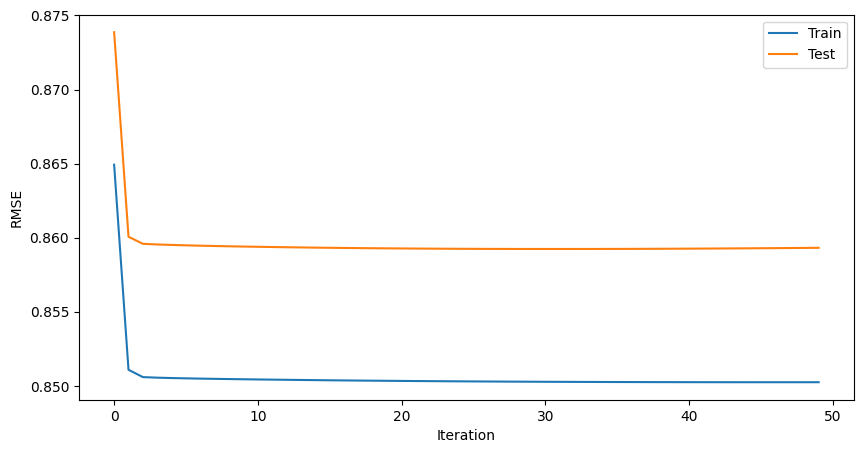

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(rmse_train_history_bias, label='Train')
plt.plot(rmse_test_history_bias, label='Test')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.legend()
plt.savefig('ALS_bias_rmse.pdf')
plt.show()

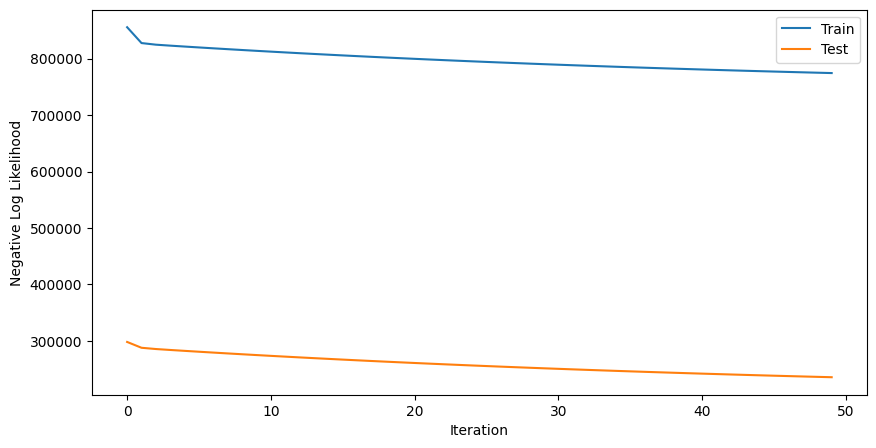

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(loss_train_history_bias, label='Train')
plt.plot(loss_test_history_bias, label='Test')
plt.xlabel('Iteration')
plt.ylabel('Negative Log Likelihood')
plt.legend()
plt.savefig('ALS_bias_loss.pdf')
plt.show()

### Final Model ALS bias and trait vector

In [ ]:
import numpy as np
import math

k = 10
par_lambda = 0.1
par_tau = 0.1
par_gamma = 0.1

user_biases = np.zeros(M, dtype=np.float64)
movie_biases = np.zeros(N, dtype=np.float64)
user_vector = np.random.normal(loc=0, scale=(1 / math.sqrt(k)), size=(M, k)).astype(np.float64)
movie_vector = np.random.normal(loc=0, scale=(1 / math.sqrt(k)), size=(N, k)).astype(np.float64)

iterations = 50
rmse_test_history = []
rmse_train_history = []
loss_test_history = []
loss_train_history = []

for i in range(iterations):
    user_biases = user_bias_update(
        user_vector, movie_vector, user_biases, movie_biases, par_lambda, par_gamma, par_tau
    )
    user_vector = user_vector_update(
        user_vector, movie_vector, user_biases, movie_biases, par_lambda, par_gamma, par_tau
    )

    movie_biases = movie_bias_update(
        user_vector, movie_vector, user_biases, movie_biases, par_lambda, par_gamma, par_tau
    )
    movie_vector = movie_vector_update(
        user_vector, movie_vector, user_biases, movie_biases, par_lambda, par_gamma, par_tau
    )

    rmse_train, loss_train = get_rmse_train(
        user_vector, movie_vector, user_biases, movie_biases, par_lambda, par_gamma, par_tau
    )

    rmse_test, loss_test = get_rmse_test(
        user_vector, movie_vector, user_biases, movie_biases, par_lambda, par_gamma, par_tau
    )
    rmse_train_history.append(rmse_train)
    rmse_test_history.append(rmse_test)
    loss_train_history.append(loss_train)
    loss_test_history.append(loss_test)

    print(f"Iteration: {i + 1}")
    print(f"RMSE_Train: {rmse_train}, RMSE_Test: {rmse_test}")
    print(f"Loss_Train: {loss_train}, Loss_Test: {loss_test}")


Iteration: 1
RMSE_Train: 0.8234512873828934, RMSE_Test: 0.9038969947221392
Loss_Train: 797331.5949254688, Loss_Test: 323451.2843063901
Iteration: 2
RMSE_Train: 0.771556971537953, RMSE_Test: 0.8624520940068304
Loss_Train: 710499.8404187178, Loss_Test: 300993.9551023351
Iteration: 3
RMSE_Train: 0.7429332399312196, RMSE_Test: 0.8350302265938189
Loss_Train: 663240.0756195278, Loss_Test: 285431.38725036394
Iteration: 4
RMSE_Train: 0.7260990897195535, RMSE_Test: 0.8180869173067482
Loss_Train: 635165.8167394632, Loss_Test: 275079.75313360384
Iteration: 5
RMSE_Train: 0.7169351778088633, RMSE_Test: 0.8089958216503866
Loss_Train: 619026.1281714806, Loss_Test: 268467.74504840124
Iteration: 6
RMSE_Train: 0.7120617172958114, RMSE_Test: 0.8043366905071985
Loss_Train: 609474.064806937, Loss_Test: 264006.28928174096
Iteration: 7
RMSE_Train: 0.70922828116999, RMSE_Test: 0.8017339351912279
Loss_Train: 603106.5246543195, Loss_Test: 260627.31026510545
Iteration: 8
RMSE_Train: 0.7073926515286698, RMSE_Test

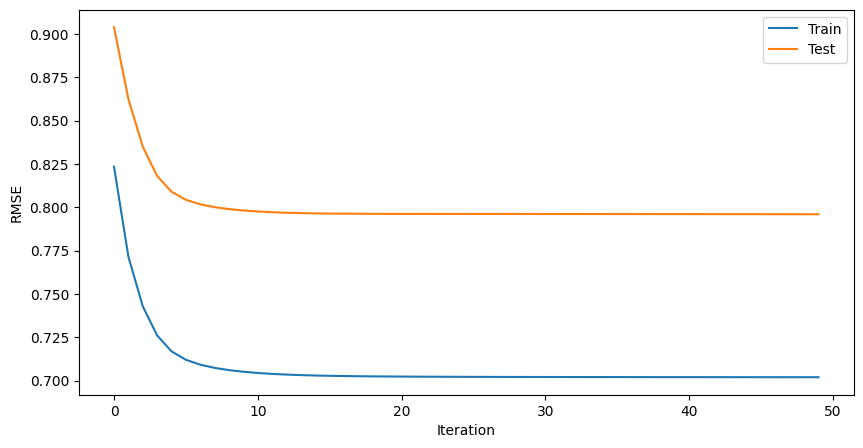

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(rmse_train_history, label='Train')
plt.plot(rmse_test_history, label='Test')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.legend()
plt.savefig('ALS_rmse.pdf')
plt.show()

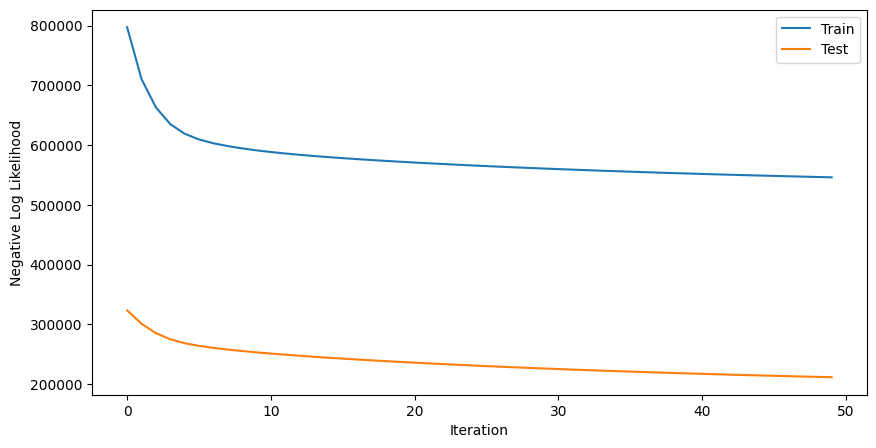

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(loss_train_history, label='Train')
plt.plot(loss_test_history, label='Test')
plt.xlabel('Iteration')
plt.ylabel('Negative Log Likelihood')
plt.legend()
plt.savefig('ALS_loss.pdf')
plt.show()

### Hyperparameter tuning: Lambda, Gamma, Tau

In [ ]:
import pickle
import numpy as np
import math

parameter_sets = [
    {'lambda': 0.001, 'gamma': 0.001, 'tau': 0.001},
    {'lambda': 0.01, 'gamma': 0.01, 'tau': 0.01},
    {'lambda': 0.05, 'gamma': 0.05, 'tau': 0.05},
    {'lambda': 0.10, 'gamma': 0.10, 'tau': 0.10},
    {'lambda': 0.15, 'gamma': 0.15, 'tau': 0.15},
    {'lambda': 0.5, 'gamma': 0.5, 'tau': 0.5}
]

iterations = 50
results = []

for params in parameter_sets:
    par_lambda = params['lambda']
    par_gamma = params['gamma']
    par_tau = params['tau']

    k = 10
    user_biases = np.zeros(M, dtype=np.float64)
    movie_biases = np.zeros(N, dtype=np.float64)
    user_vector = np.random.normal(loc=0, scale=(1 / math.sqrt(k)), size=(M, k)).astype(np.float64)
    movie_vector = np.random.normal(loc=0, scale=(1 / math.sqrt(k)), size=(N, k)).astype(np.float64)

    rmse_test_history = []
    rmse_train_history = []

    print("************************************************************")
    print(f"Lambda: {par_lambda}, Gamma: {par_gamma}, Tau: {par_tau}")
    print("************************************************************")

    for i in range(iterations):
        user_biases = user_bias_update(
            user_vector, movie_vector, user_biases, movie_biases, par_lambda, par_gamma, par_tau
        )
        user_vector = user_vector_update(
            user_vector, movie_vector, user_biases, movie_biases, par_lambda, par_gamma, par_tau
        )

        movie_biases = movie_bias_update(
            user_vector, movie_vector, user_biases, movie_biases, par_lambda, par_gamma, par_tau
        )
        movie_vector = movie_vector_update(
            user_vector, movie_vector, user_biases, movie_biases, par_lambda, par_gamma, par_tau
        )

        rmse_train, _ = get_rmse_train(
            user_vector, movie_vector, user_biases, movie_biases, par_lambda, par_gamma, par_tau
        )
        rmse_test, _ = get_rmse_test(
            user_vector, movie_vector, user_biases, movie_biases, par_lambda, par_gamma, par_tau
        )

        rmse_train_history.append(rmse_train)
        rmse_test_history.append(rmse_test)

        print(f"Iteration: {i + 1}")
        print(f"RMSE_Train: {rmse_train}, RMSE_Test: {rmse_test}")

    results.append({
        'lambda': par_lambda,
        'gamma': par_gamma,
        'tau': par_tau,
        'rmse_train_history': rmse_train_history,
        'rmse_test_history': rmse_test_history
    })

# Save results to a file
with open('als_results.pkl', 'wb') as f:
    pickle.dump(results, f)

print("Results saved to als_results.pkl")

************************************************************
Lambda: 0.001, Gamma: 0.001, Tau: 0.001
************************************************************
Iteration: 1
RMSE_Train: 0.8246460869859426, RMSE_Test: 0.9053618172344305
Iteration: 2
RMSE_Train: 0.7739200760624568, RMSE_Test: 0.8660431551614051
Iteration: 3
RMSE_Train: 0.7457568069308421, RMSE_Test: 0.8392961745957502
Iteration: 4
RMSE_Train: 0.7289682246972008, RMSE_Test: 0.8222568052828356
Iteration: 5
RMSE_Train: 0.7194077893566129, RMSE_Test: 0.8125070501259977
Iteration: 6
RMSE_Train: 0.7139402961489658, RMSE_Test: 0.8069930662888983
Iteration: 7
RMSE_Train: 0.7105478280192532, RMSE_Test: 0.8036181090672202
Iteration: 8
RMSE_Train: 0.7082900458253398, RMSE_Test: 0.8013927297558661
Iteration: 9
RMSE_Train: 0.7067215641771124, RMSE_Test: 0.7998536672053254
Iteration: 10
RMSE_Train: 0.7056042462492712, RMSE_Test: 0.7987603261464573
Iteration: 11
RMSE_Train: 0.7047961770953336, RMSE_Test: 0.7979741851408161
Iteration: 

### Hyperparameter tuning: k

In [ ]:
import numpy as np
import math

k = 5
par_lambda = 0.1
par_tau = 0.1
par_gamma = 0.1

user_biases = np.zeros(M, dtype=np.float64)
movie_biases = np.zeros(N, dtype=np.float64)
user_vector = np.random.normal(loc=0, scale=(1 / math.sqrt(k)), size=(M, k)).astype(np.float64)
movie_vector = np.random.normal(loc=0, scale=(1 / math.sqrt(k)), size=(N, k)).astype(np.float64)

iterations = 50
rmse_test_history_5 = []

for i in range(iterations):
    user_biases = user_bias_update(
        user_vector, movie_vector, user_biases, movie_biases, par_lambda, par_gamma, par_tau
    )
    user_vector = user_vector_update(
        user_vector, movie_vector, user_biases, movie_biases, par_lambda, par_gamma, par_tau
    )

    movie_biases = movie_bias_update(
        user_vector, movie_vector, user_biases, movie_biases, par_lambda, par_gamma, par_tau
    )
    movie_vector = movie_vector_update(
        user_vector, movie_vector, user_biases, movie_biases, par_lambda, par_gamma, par_tau
    )

    rmse_test, loss_test = get_rmse_test(
        user_vector, movie_vector, user_biases, movie_biases, par_lambda, par_gamma, par_tau
    )
    rmse_test_history_5.append(rmse_test)

    print(f"Iteration: {i + 1}")
    print(f"RMSE_Test: {rmse_test}, Loss_Test: {loss_test}")

In [ ]:
import numpy as np
import math

k = 10
par_lambda = 0.1
par_tau = 0.1
par_gamma = 0.1

user_biases = np.zeros(M, dtype=np.float64)
movie_biases = np.zeros(N, dtype=np.float64)
user_vector = np.random.normal(loc=0, scale=(1 / math.sqrt(k)), size=(M, k)).astype(np.float64)
movie_vector = np.random.normal(loc=0, scale=(1 / math.sqrt(k)), size=(N, k)).astype(np.float64)

iterations = 50
rmse_test_history_10 = []

for i in range(iterations):
    user_biases = user_bias_update(
        user_vector, movie_vector, user_biases, movie_biases, par_lambda, par_gamma, par_tau
    )
    user_vector = user_vector_update(
        user_vector, movie_vector, user_biases, movie_biases, par_lambda, par_gamma, par_tau
    )

    movie_biases = movie_bias_update(
        user_vector, movie_vector, user_biases, movie_biases, par_lambda, par_gamma, par_tau
    )
    movie_vector = movie_vector_update(
        user_vector, movie_vector, user_biases, movie_biases, par_lambda, par_gamma, par_tau
    )

    rmse_test, loss_test = get_rmse_test(
        user_vector, movie_vector, user_biases, movie_biases, par_lambda, par_gamma, par_tau
    )
    rmse_test_history_10.append(rmse_test)

    print(f"Iteration: {i + 1}")
    print(f"RMSE_Test: {rmse_test}, Loss_Test: {loss_test}")

In [ ]:
import numpy as np
import math

k = 15
par_lambda = 0.1
par_tau = 0.1
par_gamma = 0.1

user_biases = np.zeros(M, dtype=np.float64)
movie_biases = np.zeros(N, dtype=np.float64)
user_vector = np.random.normal(loc=0, scale=(1 / math.sqrt(k)), size=(M, k)).astype(np.float64)
movie_vector = np.random.normal(loc=0, scale=(1 / math.sqrt(k)), size=(N, k)).astype(np.float64)

iterations = 50
rmse_test_history_15 = []

for i in range(iterations):
    user_biases = user_bias_update(
        user_vector, movie_vector, user_biases, movie_biases, par_lambda, par_gamma, par_tau
    )
    user_vector = user_vector_update(
        user_vector, movie_vector, user_biases, movie_biases, par_lambda, par_gamma, par_tau
    )

    movie_biases = movie_bias_update(
        user_vector, movie_vector, user_biases, movie_biases, par_lambda, par_gamma, par_tau
    )
    movie_vector = movie_vector_update(
        user_vector, movie_vector, user_biases, movie_biases, par_lambda, par_gamma, par_tau
    )

    rmse_test, loss_test = get_rmse_test(
        user_vector, movie_vector, user_biases, movie_biases, par_lambda, par_gamma, par_tau
    )
    rmse_test_history_15.append(rmse_test)

    print(f"Iteration: {i + 1}")
    print(f"RMSE_Test: {rmse_test}, Loss_Test: {loss_test}")

In [ ]:
import numpy as np
import math

k = 20
par_lambda = 0.1
par_tau = 0.1
par_gamma = 0.1

user_biases = np.zeros(M, dtype=np.float64)
movie_biases = np.zeros(N, dtype=np.float64)
user_vector = np.random.normal(loc=0, scale=(1 / math.sqrt(k)), size=(M, k)).astype(np.float64)
movie_vector = np.random.normal(loc=0, scale=(1 / math.sqrt(k)), size=(N, k)).astype(np.float64)

iterations = 50
rmse_test_history_20 = []

for i in range(iterations):
    user_biases = user_bias_update(
        user_vector, movie_vector, user_biases, movie_biases, par_lambda, par_gamma, par_tau
    )
    user_vector = user_vector_update(
        user_vector, movie_vector, user_biases, movie_biases, par_lambda, par_gamma, par_tau
    )

    movie_biases = movie_bias_update(
        user_vector, movie_vector, user_biases, movie_biases, par_lambda, par_gamma, par_tau
    )
    movie_vector = movie_vector_update(
        user_vector, movie_vector, user_biases, movie_biases, par_lambda, par_gamma, par_tau
    )

    rmse_test, loss_test = get_rmse_test(
        user_vector, movie_vector, user_biases, movie_biases, par_lambda, par_gamma, par_tau
    )
    rmse_test_history_20.append(rmse_test)

    print(f"Iteration: {i + 1}")
    print(f"RMSE_Test: {rmse_test}, Loss_Test: {loss_test}")

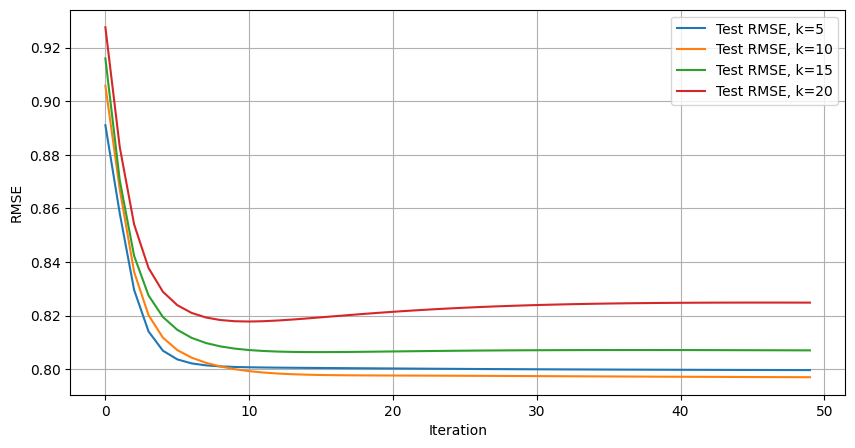

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(rmse_test_history_5, label='Test RMSE, k=5')
plt.plot(rmse_test_history_10, label='Test RMSE, k=10')
plt.plot(rmse_test_history_15, label='Test RMSE, k=15')
plt.plot(rmse_test_history_20, label='Test RMSE, k=20')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.legend()
plt.savefig('rmse_train_k.pdf')
plt.show()